<a href="https://colab.research.google.com/github/winkler-eva/CovidClassifierBIOINF/blob/main/CovidClassifier_with_Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>Covid-Classifier</strong></h1>

In [1]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 194kB 7.8MB/s 
     |████████████████████████████████| 12.8MB 225kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
import fastai
print(fastai.__version__)

2.3.0


In [3]:
import os
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

<h2>Save images permanently in google drive</h2>

In [19]:
# data was downloaded from the website kaggle.com
#kein zweites mal ausführen, sonst wird's überschrieben!
#!tar -czvf covid_images.tar.gz covid_data 

covid_data/
covid_data/non_covid/
covid_data/non_covid/4%1.jpg
covid_data/non_covid/18%1.jpg
covid_data/non_covid/15%1.jpg
covid_data/non_covid/7.jpg
covid_data/non_covid/5%0.jpg
covid_data/non_covid/10%1.jpg
covid_data/non_covid/17%1.jpg
covid_data/non_covid/8.jpg
covid_data/non_covid/14%2.jpg
covid_data/non_covid/31.jpg
covid_data/non_covid/33.png
covid_data/non_covid/18%2.jpg
covid_data/non_covid/38%0.jpg
covid_data/non_covid/5%1.jpg
covid_data/non_covid/6%0.jpg
covid_data/non_covid/26%0.jpg
covid_data/non_covid/36%1.jpg
covid_data/non_covid/10%0.jpg
covid_data/non_covid/30%2.jpg
covid_data/non_covid/43.png
covid_data/non_covid/39%3.jpg
covid_data/non_covid/23.png
covid_data/non_covid/30%3.jpg
covid_data/non_covid/29%1.jpg
covid_data/non_covid/37%4.jpg
covid_data/non_covid/22%1.jpg
covid_data/non_covid/6%1.jpg
covid_data/non_covid/5%7.jpg
covid_data/non_covid/6%3.jpg
covid_data/non_covid/15%3.jpg
covid_data/non_covid/32%0.jpg
covid_data/non_covid/25%0.jpg
covid_data/non_covid/37%0.j

In [20]:
# kein zweites mal ausführen, sonst wird's überschrieben!
#!cp -av covid_images.tar.gz /content/drive/My\ Drive/BIOINF 

'covid_images.tar.gz' -> '/content/drive/My Drive/BIOINF/covid_images.tar.gz'


In [4]:
!cp /content/drive/My\ Drive/BIOINF/covid_images.tar.gz covid_project/

In [5]:
!tar -xf covid_project/covid_images.tar.gz -C covid_project/

<h2>Dataloader</h2>

In [6]:
path = Path('covid_project')
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);

In [7]:
covid = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    # splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
) 

In [8]:
dls = covid.dataloaders(path, bs=64)

<h2>Normalize trainings dataset</h2>

In [9]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.6672, 0.6671, 0.6676], device='cuda:0'),
 TensorImage([0.2935, 0.2939, 0.2938], device='cuda:0'))

In [10]:
def get_dls(bs, size):
  covid = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    # splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(460),
    batch_tfms = [*aug_transforms(size=224, min_scale=0.75),
                                Normalize.from_stats(*imagenet_stats)])
  return covid.dataloaders(path, bs=bs)

In [11]:
dls = get_dls(64, 224)

In [12]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.7445, 0.8888, 1.1079], device='cuda:0'),
 TensorImage([1.3439, 1.3758, 1.3699], device='cuda:0'))

In [13]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.343591,7.928845,0.020000,00:07
1,4.255968,1.374622,0.500000,00:03
2,3.182541,0.938274,0.520000,00:03
3,2.524809,0.702785,0.520000,00:04
4,2.092222,0.734085,0.600000,00:04


<h2>Progressive Resizing</h2>



In [ ]:
# Hat nicht funktioniert - Problem mit der GPU
# dls = get_dls(128, 128)
# learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
# learn.fit_one_cycle(4, 3e-3)

In [ ]:
# learn.dls = get_dls(64, 224)
# learn.fine_tune(5, 5e-3)

<h2>Test-Time Augumentation</h2>

In [14]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.5400000214576721

<h2>Label Smoothing</h2>

In [15]:
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.840226,7.862442,0.000000,00:03
1,4.987080,5.111762,0.460000,00:04
2,4.004160,9.881581,0.480000,00:04
3,3.487746,5.215366,0.520000,00:04
4,3.157596,3.941422,0.500000,00:04


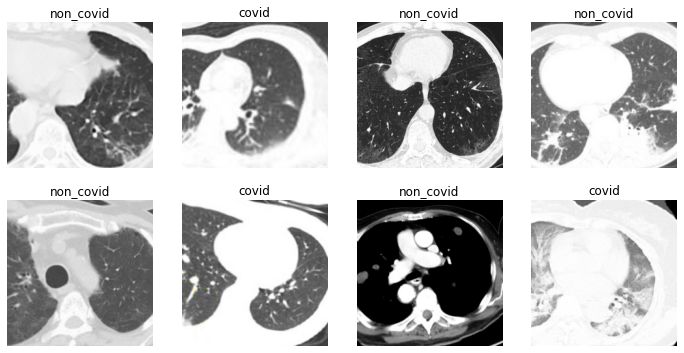

In [16]:
dls.show_batch(max_n=8, nrows=2)

<h2>Train learner</h2>

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.445547,1.989856,0.480000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.925540,1.352665,0.500000,00:02
1,0.920115,1.249701,0.460000,00:02
2,0.869694,1.178472,0.400000,00:02
3,0.790366,1.174079,0.300000,00:02
4,0.685684,1.068255,0.280000,00:02
5,0.620534,0.974386,0.260000,00:02
6,0.571447,0.918525,0.260000,00:02
7,0.525574,0.892466,0.260000,00:02
8,0.484091,0.835357,0.240000,00:02
9,0.463742,0.800106,0.260000,00:02


<h2>Export learner</h2>

In [18]:
learn.export('covid_classifier.pkl')

In [19]:
# Check if path exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('covid_classifier.pkl')]

In [37]:
# Save covid_classifier.pkl on google drive
# !cp /content/covid_classifier.pkl /content/drive/My\ Drive/BIOINF/covid_classifier.pkl

<h2>Import learner + inference</h2>

In [20]:
# Uncomment line to copy learner from google drive
!cp /content/drive/My\ Drive/BIOINF/covid_classifier.pkl ./ 

In [21]:
inference = load_learner(path/'covid_classifier.pkl')

In [22]:
# Save test image on google drive
# !cp /content/Testbild.jpeg /content/drive/My\ Drive/BIOINF/
!cp /content/drive/My\ Drive/BIOINF/Testbild.jpeg ./

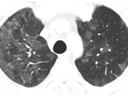

In [23]:
img = Image.open('Testbild.jpeg')
img.to_thumb(128,128)

In [24]:
inference.predict('Testbild.jpeg')
# inference.predict('Testbild_gesund.jpg')

('non_covid', tensor(1), tensor([0.0110, 0.9890]))

In [25]:
inference.dls.vocab

['covid', 'non_covid']

<h2>User Interface</h2>

In [26]:
import ipywidgets as widgets

In [27]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [28]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [29]:
img = PILImage.create(btn_upload.data[-1])

In [30]:
pred, pred_idx, probs = inference.predict(img)

In [31]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: covid; Probability: 0.8644')

In [32]:
btn_run = widgets.Button(description='Classify Covid')
btn_run

Button(description='Classify Covid', style=ButtonStyle())

In [33]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = inference.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [34]:
btn_upload = widgets.FileUpload()
widgets.VBox([widgets.Label("Select lung CT:"),
             btn_upload, btn_run, out_pl, lbl_pred])


<h2>Confusion Matrix</h2>



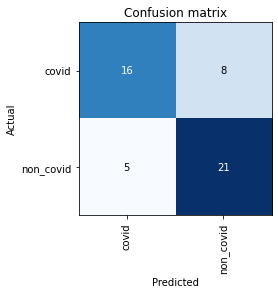

In [35]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

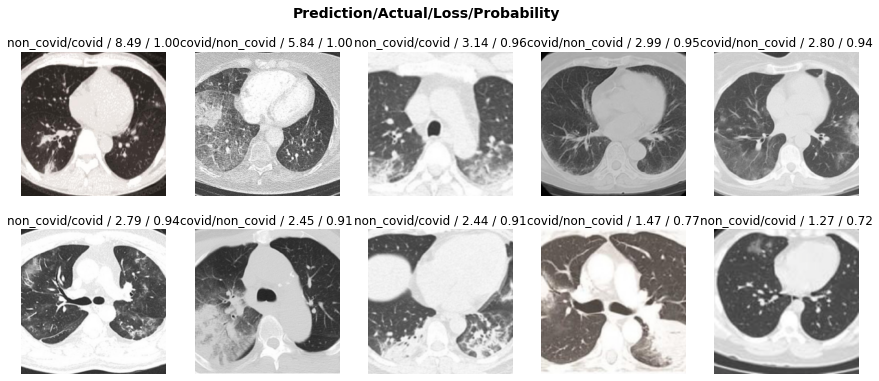

In [37]:
interpret.plot_top_losses(10, nrows=2)